In [2]:
import os
import wfdb
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

def load_mitbih_dataset(path):
    annots_list = ['N', 'L', 'R', 'e', 'j', 'S', 'A', 'a', 'J', 'V', 'E', 'F', '/', 'f', 'Q']
    X = []
    y = []
    annot_to_int = {annot: i for i, annot in enumerate(annots_list)}

    record_list = []
    with open(os.path.join(path, 'RECORDS'), 'r') as file:
        record_list = [line.strip() for line in file]

    scaler = MinMaxScaler(feature_range=(0, 1))

    for record_name in record_list:
        record = wfdb.rdrecord(os.path.join(path, record_name))
        annotation = wfdb.rdann(os.path.join(path, record_name), 'atr')
        signal = record.p_signal[:, 0]
        beat_annotations = annotation.symbol
        beat_locations = annotation.sample

        for sym, loc in zip(beat_annotations, beat_locations):
            if sym in annots_list:
                label = annot_to_int[sym]
                win_size = 625
                if loc - win_size >= 0 and loc + win_size <= len(signal):
                    segment = signal[loc - win_size: loc + win_size]
                    segment = scaler.fit_transform(segment.reshape(-1, 1)).flatten()
                    X.append(segment)
                    y.append(label)

    X = np.array(X)
    y = to_categorical(y, num_classes=len(annots_list))

    return X, y


In [5]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, TimeDistributed, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import KFold
import json
import time

# Function to create the LSTM model with Conv1D layers
def create_lstm_model(num_classes, input_shape=(1250, 1), optimizer_type='adam', learning_rate=0.001):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Convolutional layers with BatchNormalization
    x = Conv1D(32, 5, strides=1, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv1D(64, 5, strides=1, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv1D(128, 5, strides=1, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    # TimeDistributed Flatten layer to prepare for LSTM
    x = TimeDistributed(Flatten())(x)
    
    # LSTM layer with 200 units
    x = LSTM(200, return_sequences=False)(x)
    x = Dropout(0.5)(x)  # Dropout layer for regularization
    
    # Dense layers with Dropout
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Output layer with softmax activation for classification
    outputs = Dense(num_classes, activation='softmax')(x)

    # Select optimizer
    if optimizer_type == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)

    # Compile the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
    
    return model

# Function to perform cross-validation
def cross_validate_model(X, y, k=10,epochs=10):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_no = 1
    all_results = []
    total_start_time = time.time()  # Start time for the entire cross-validation process

    for train, test in kfold.split(X, y):
        print(f'Training fold {fold_no}...')
        fold_start_time = time.time()  # Start time for the current fold
        
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        
        model = create_lstm_model(num_classes=y_train.shape[1], input_shape=(X_train.shape[1], 1))
        # Dynamic file path for each fold
        model_checkpoint_path = f'./model_fold_{fold_no}.h5'

        callbacks = [
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1),
            keras.callbacks.ModelCheckpoint(model_checkpoint_path, save_best_only=True, verbose=1),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
        ]
        
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_test, y_test), callbacks=callbacks)
        
        fold_end_time = time.time()
        fold_elapsed_time = fold_end_time - fold_start_time  # Elapsed time for the current fold
        print(f'Fold {fold_no} completed in {fold_elapsed_time:.2f} seconds.')
        
        results = model.evaluate(X_test, y_test, verbose=1)
        all_results.append(results)
        
        fold_no += 1

    total_end_time = time.time()
    total_elapsed_time = total_end_time - total_start_time  # Total elapsed time for the cross-validation
    print(f'Total cross-validation time: {total_elapsed_time:.2f} seconds.')

    return all_results, total_elapsed_time

# Load and preprocess data
data_path = "/home/researchgroup/mahjabeen_workspace/research/CLINet-ECG-Classification-2024/data/mit-bih/mitbih_database/"
X, y = load_mitbih_dataset(data_path)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Perform cross-validation
results, total_time = cross_validate_model(X, y, k=10)

# Save results
with open('cross_validation_results.json', 'w') as f:
    json.dump(results, f)

print("Cross-validation completed. Results saved.")


Training fold 1...
Epoch 1/10
1537/1537 [==============================] - ETA: 0s - loss: 0.9132 - accuracy: 0.7462 - precision_3: 0.7907 - recall_3: 0.6699
Epoch 1: val_loss improved from inf to 1.84618, saving model to ./model_fold_1.h5
1537/1537 [==============================] - 104s 66ms/step - loss: 0.9132 - accuracy: 0.7462 - precision_3: 0.7907 - recall_3: 0.6699 - val_loss: 1.8462 - val_accuracy: 0.4252 - val_precision_3: 0.2524 - val_recall_3: 0.0834 - lr: 0.0010
Epoch 2/10
   2/1537 [..............................] - ETA: 1:45 - loss: 0.8182 - accuracy: 0.7734 - precision_3: 0.7739 - recall_3: 0.6953

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1537/1537 [==============================] - ETA: 0s - loss: 0.7201 - accuracy: 0.7940 - precision_3: 0.8432 - recall_3: 0.7349
Epoch 2: val_loss improved from 1.84618 to 0.52726, saving model to ./model_fold_1.h5
1537/1537 [==============================] - 100s 65ms/step - loss: 0.7201 - accuracy: 0.7940 - precision_3: 0.8432 - recall_3: 0.7349 - val_loss: 0.5273 - val_accuracy: 0.8436 - val_precision_3: 0.8749 - val_recall_3: 0.8123 - lr: 0.0010
Epoch 3/10
1537/1537 [==============================] - ETA: 0s - loss: 0.7987 - accuracy: 0.7713 - precision_3: 0.8076 - recall_3: 0.7201
Epoch 3: val_loss did not improve from 0.52726
1537/1537 [==============================] - 101s 66ms/step - loss: 0.7987 - accuracy: 0.7713 - precision_3: 0.8076 - recall_3: 0.7201 - val_loss: 0.6616 - val_accuracy: 0.7795 - val_precision_3: 0.8650 - val_recall_3: 0.7116 - lr: 0.0010
Epoch 4/10
1537/1537 [==============================] - ETA: 0s - loss: 0.6398 - accuracy: 0.8121 - precision_3: 0.8513 - 

In [5]:
unique_classes = np.unique(np.argmax(y, axis=1))
print("Unique classes in the dataset:", unique_classes)
print("Number of unique classes:", len(unique_classes))


Unique classes in the dataset: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Number of unique classes: 15


Model for fold 1 loaded successfully.
342/342 [==============================] - 9s 26ms/step - loss: 0.2603 - accuracy: 0.9126 - precision_3: 0.9241 - recall_3: 0.9015
Test Loss, Test Accuracy, and other metrics for fold 1: [0.26031213998794556, 0.9126178026199341, 0.9241159558296204, 0.9014548659324646]
Evaluation time for fold 1: 9.24 seconds
342/342 [==============================] - 7s 20ms/step

Classification Report for fold 1:
              precision    recall  f1-score   support

           N       0.91      0.99      0.95      7506
           L       0.95      0.98      0.96       806
           R       0.95      0.97      0.96       775
           e       0.00      0.00      0.00         1
           j       0.00      0.00      0.00        31
           A       0.86      0.57      0.68       221
           a       0.00      0.00      0.00        14
           J       0.00      0.00      0.00         8
           V       0.84      0.14      0.24       692
           E       0

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

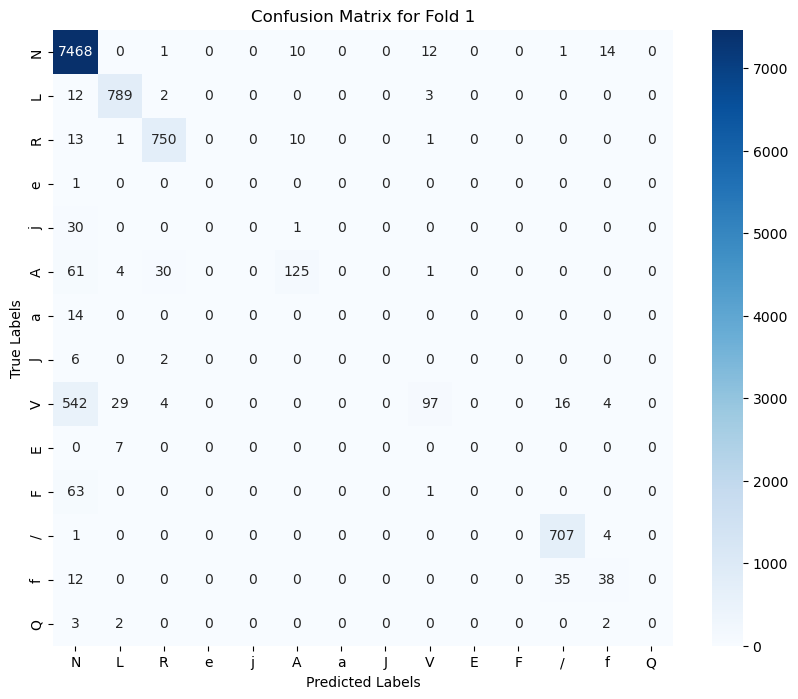

Model for fold 2 loaded successfully.
342/342 [==============================] - 9s 26ms/step - loss: 0.3384 - accuracy: 0.8848 - precision_4: 0.9001 - recall_4: 0.8746
Test Loss, Test Accuracy, and other metrics for fold 2: [0.3384236693382263, 0.8848019242286682, 0.9000941514968872, 0.8746454119682312]
Evaluation time for fold 2: 9.51 seconds
342/342 [==============================] - 7s 20ms/step

Classification Report for fold 2:
              precision    recall  f1-score   support

           N       0.88      1.00      0.93      7489
           L       0.95      0.92      0.93       788
           R       0.96      0.91      0.94       725
           e       0.00      0.00      0.00         1
           j       0.00      0.00      0.00        18
           S       0.00      0.00      0.00         1
           A       0.81      0.48      0.60       246
           a       0.00      0.00      0.00        13
           J       0.00      0.00      0.00         4
           V       0.

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

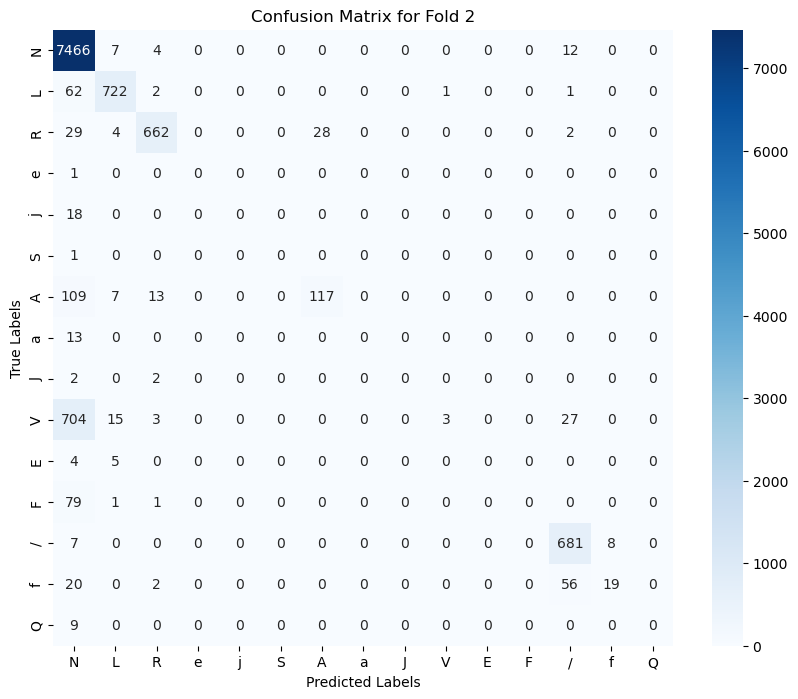

Model for fold 3 loaded successfully.
342/342 [==============================] - 10s 27ms/step - loss: 0.3261 - accuracy: 0.8954 - precision_5: 0.9157 - recall_5: 0.8743
Test Loss, Test Accuracy, and other metrics for fold 3: [0.32613301277160645, 0.8954158425331116, 0.9156684279441833, 0.8742794394493103]
Evaluation time for fold 3: 9.65 seconds
342/342 [==============================] - 7s 21ms/step

Classification Report for fold 3:
              precision    recall  f1-score   support

           N       0.89      0.99      0.94      7514
           L       0.95      0.93      0.94       849
           R       0.96      0.90      0.93       731
           j       0.00      0.00      0.00        23
           A       0.77      0.52      0.62       247
           a       0.00      0.00      0.00        11
           J       0.00      0.00      0.00         8
           V       0.62      0.15      0.24       707
           E       0.00      0.00      0.00        10
           F       

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

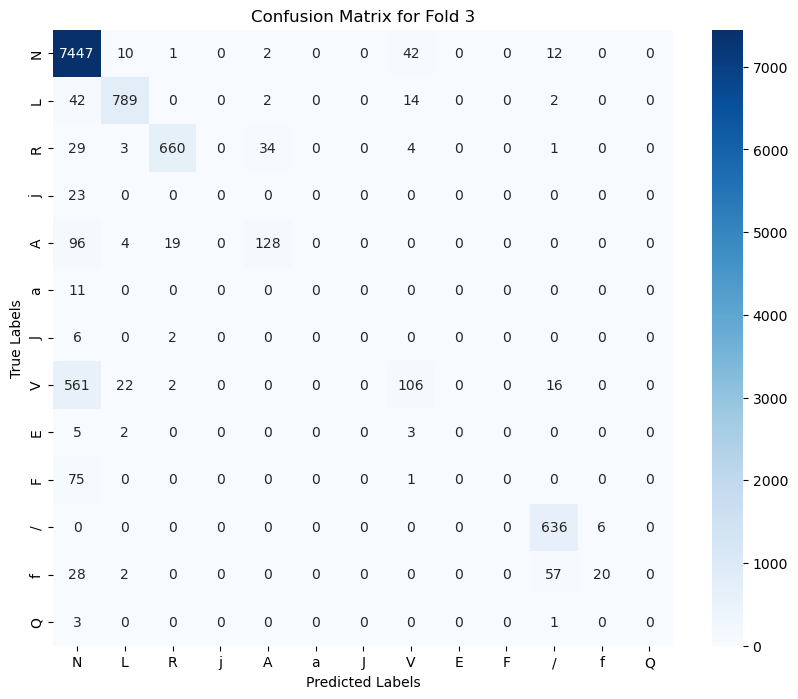

Model for fold 4 loaded successfully.
342/342 [==============================] - 9s 26ms/step - loss: 0.3262 - accuracy: 0.8860 - precision_6: 0.8944 - recall_6: 0.8796
Test Loss, Test Accuracy, and other metrics for fold 4: [0.3261929750442505, 0.8859913945198059, 0.8943989872932434, 0.879586398601532]
Evaluation time for fold 4: 9.24 seconds
342/342 [==============================] - 7s 19ms/step

Classification Report for fold 4:
              precision    recall  f1-score   support

           N       0.88      0.99      0.93      7490
           L       0.93      0.93      0.93       833
           R       0.95      0.91      0.93       711
           e       0.00      0.00      0.00         2
           j       0.00      0.00      0.00        21
           S       0.00      0.00      0.00         1
           A       0.80      0.48      0.60       251
           a       0.00      0.00      0.00        15
           J       0.00      0.00      0.00         7
           V       1.0

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

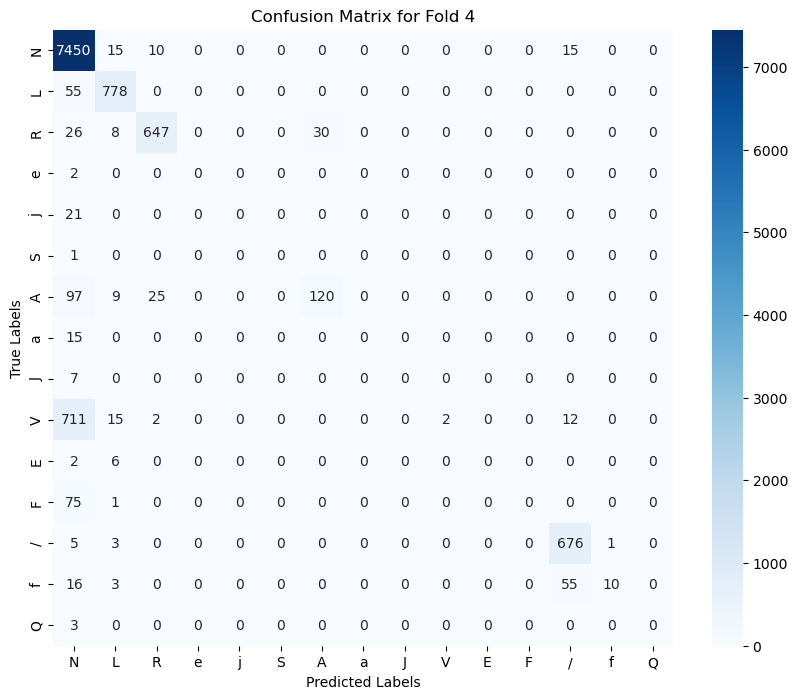

Model for fold 5 loaded successfully.
342/342 [==============================] - 9s 25ms/step - loss: 0.3661 - accuracy: 0.8811 - precision_7: 0.8869 - recall_7: 0.8757
Test Loss, Test Accuracy, and other metrics for fold 5: [0.3661406636238098, 0.8811419010162354, 0.8868606090545654, 0.8757434487342834]
Evaluation time for fold 5: 9.03 seconds
342/342 [==============================] - 7s 20ms/step

Classification Report for fold 5:
              precision    recall  f1-score   support

           N       0.87      0.99      0.93      7491
           L       0.93      0.89      0.91       799
           R       0.96      0.92      0.94       749
           e       0.00      0.00      0.00         2
           j       0.00      0.00      0.00        20
           A       0.76      0.54      0.63       278
           a       0.00      0.00      0.00        14
           J       0.00      0.00      0.00         5
           V       0.00      0.00      0.00       718
           E       0.

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

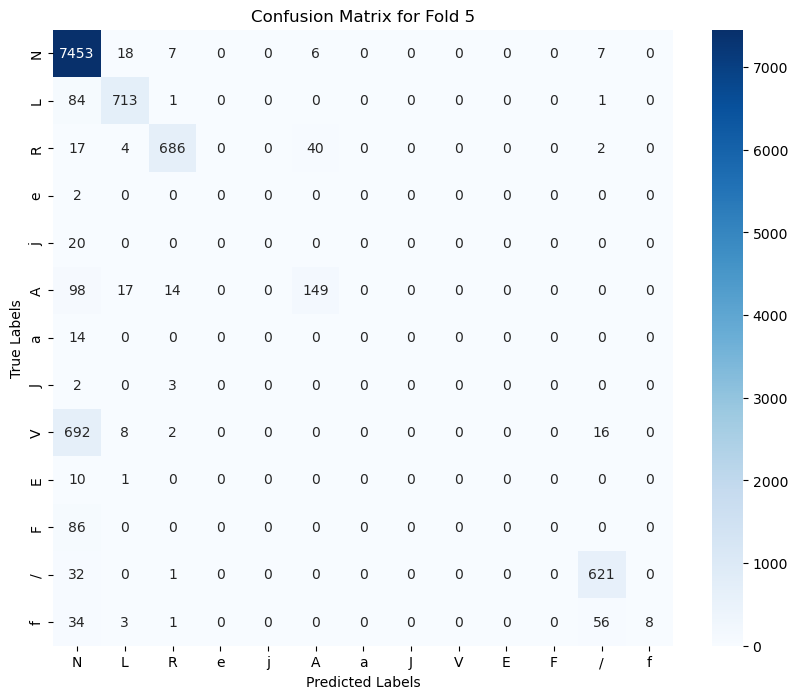

Model for fold 6 loaded successfully.
342/342 [==============================] - 9s 25ms/step - loss: 0.3310 - accuracy: 0.8920 - precision_8: 0.9096 - recall_8: 0.8773
Test Loss, Test Accuracy, and other metrics for fold 6: [0.3310488164424896, 0.8920303583145142, 0.9095911383628845, 0.8772989511489868]
Evaluation time for fold 6: 9.17 seconds
342/342 [==============================] - 7s 21ms/step

Classification Report for fold 6:
              precision    recall  f1-score   support

           N       0.91      0.97      0.94      7409
           L       0.85      0.97      0.91       769
           R       0.95      0.95      0.95       752
           j       0.00      0.00      0.00        25
           A       0.89      0.42      0.57       257
           a       0.00      0.00      0.00        17
           J       0.00      0.00      0.00        12
           V       0.56      0.32      0.41       750
           E       0.00      0.00      0.00        13
           F       0.

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

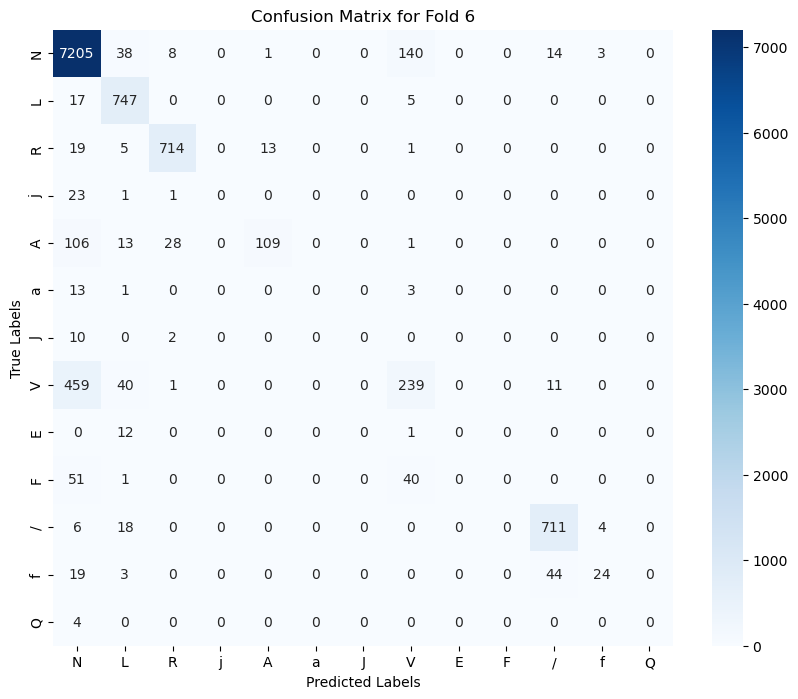

Model for fold 7 loaded successfully.
342/342 [==============================] - 9s 25ms/step - loss: 0.3055 - accuracy: 0.8918 - precision_9: 0.8975 - recall_9: 0.8857
Test Loss, Test Accuracy, and other metrics for fold 7: [0.3055456578731537, 0.8917558789253235, 0.8974596858024597, 0.8857169151306152]
Evaluation time for fold 7: 9.22 seconds
342/342 [==============================] - 7s 21ms/step

Classification Report for fold 7:
              precision    recall  f1-score   support

           N       0.88      1.00      0.94      7485
           L       0.97      0.95      0.96       792
           R       0.95      0.94      0.94       715
           e       0.00      0.00      0.00         2
           j       0.00      0.00      0.00        27
           A       0.86      0.47      0.61       281
           a       0.00      0.00      0.00        24
           J       0.00      0.00      0.00        12
           V       0.39      0.02      0.04       707
           E       0.

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

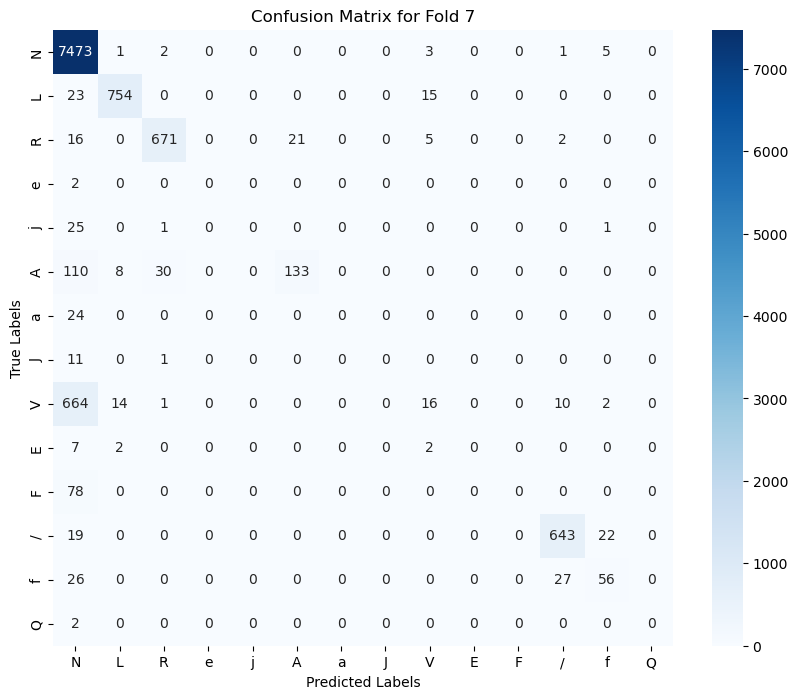

Model for fold 8 loaded successfully.
342/342 [==============================] - 9s 26ms/step - loss: 0.2912 - accuracy: 0.8960 - precision_10: 0.9042 - recall_10: 0.8915
Test Loss, Test Accuracy, and other metrics for fold 8: [0.29124605655670166, 0.8959553241729736, 0.9042138457298279, 0.8914714455604553]
Evaluation time for fold 8: 9.42 seconds
342/342 [==============================] - 7s 19ms/step

Classification Report for fold 8:
              precision    recall  f1-score   support

           N       0.89      1.00      0.94      7549
           L       0.94      0.95      0.95       781
           R       0.96      0.93      0.95       687
           e       0.00      0.00      0.00         1
           j       0.00      0.00      0.00        29
           A       0.88      0.57      0.69       264
           a       0.00      0.00      0.00         8
           J       0.00      0.00      0.00         4
           V       0.50      0.00      0.01       706
           E      

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

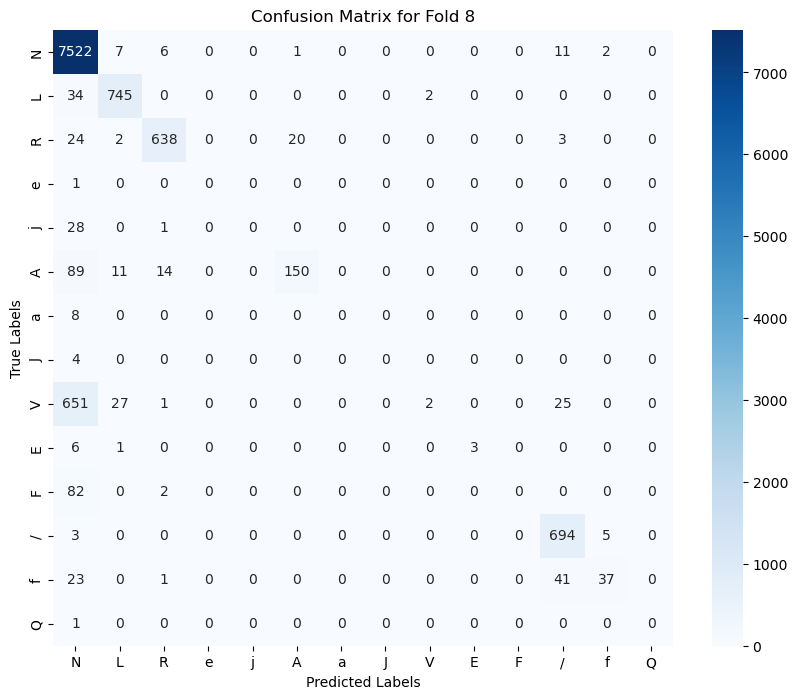

Model for fold 9 loaded successfully.
342/342 [==============================] - 9s 26ms/step - loss: 0.3440 - accuracy: 0.8885 - precision_11: 0.9012 - recall_11: 0.8788
Test Loss, Test Accuracy, and other metrics for fold 9: [0.3440340757369995, 0.8884516954421997, 0.9011824131011963, 0.878751814365387]
Evaluation time for fold 9: 9.22 seconds
342/342 [==============================] - 7s 19ms/step

Classification Report for fold 9:
              precision    recall  f1-score   support

           N       0.88      0.99      0.93      7472
           L       0.95      0.90      0.92       793
           R       0.97      0.93      0.95       682
           e       0.00      0.00      0.00         2
           j       0.00      0.00      0.00        21
           A       0.85      0.53      0.66       249
           a       0.00      0.00      0.00        21
           J       0.00      0.00      0.00        10
           V       0.65      0.12      0.20       710
           E       0

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

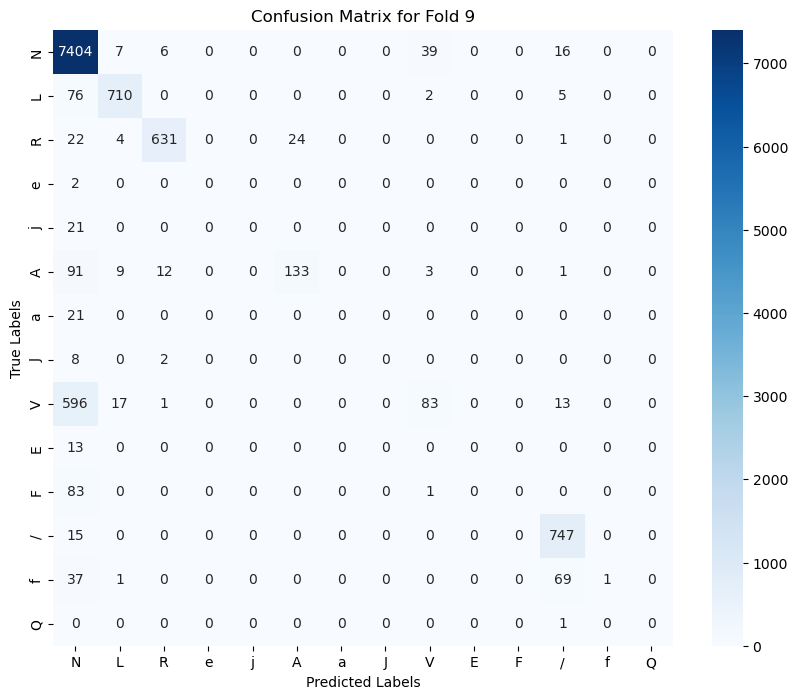

Model for fold 10 loaded successfully.
342/342 [==============================] - 9s 26ms/step - loss: 0.3335 - accuracy: 0.8908 - precision_12: 0.9004 - recall_12: 0.8814
Test Loss, Test Accuracy, and other metrics for fold 10: [0.3335370719432831, 0.8908308744430542, 0.9003552198410034, 0.8814055919647217]
Evaluation time for fold 10: 9.33 seconds
342/342 [==============================] - 7s 19ms/step

Classification Report for fold 10:
              precision    recall  f1-score   support

           N       0.89      0.99      0.94      7501
           L       0.87      0.91      0.89       850
           R       0.96      0.90      0.93       718
           e       0.00      0.00      0.00         5
           j       0.00      0.00      0.00        14
           A       0.78      0.44      0.56       248
           a       0.00      0.00      0.00        13
           J       0.00      0.00      0.00        13
           V       0.00      0.00      0.00       637
           E   

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

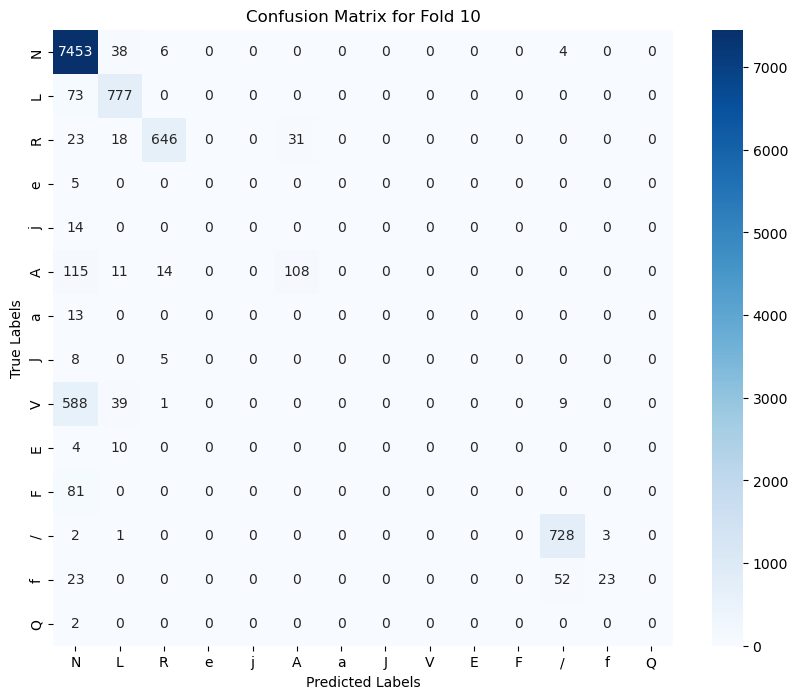

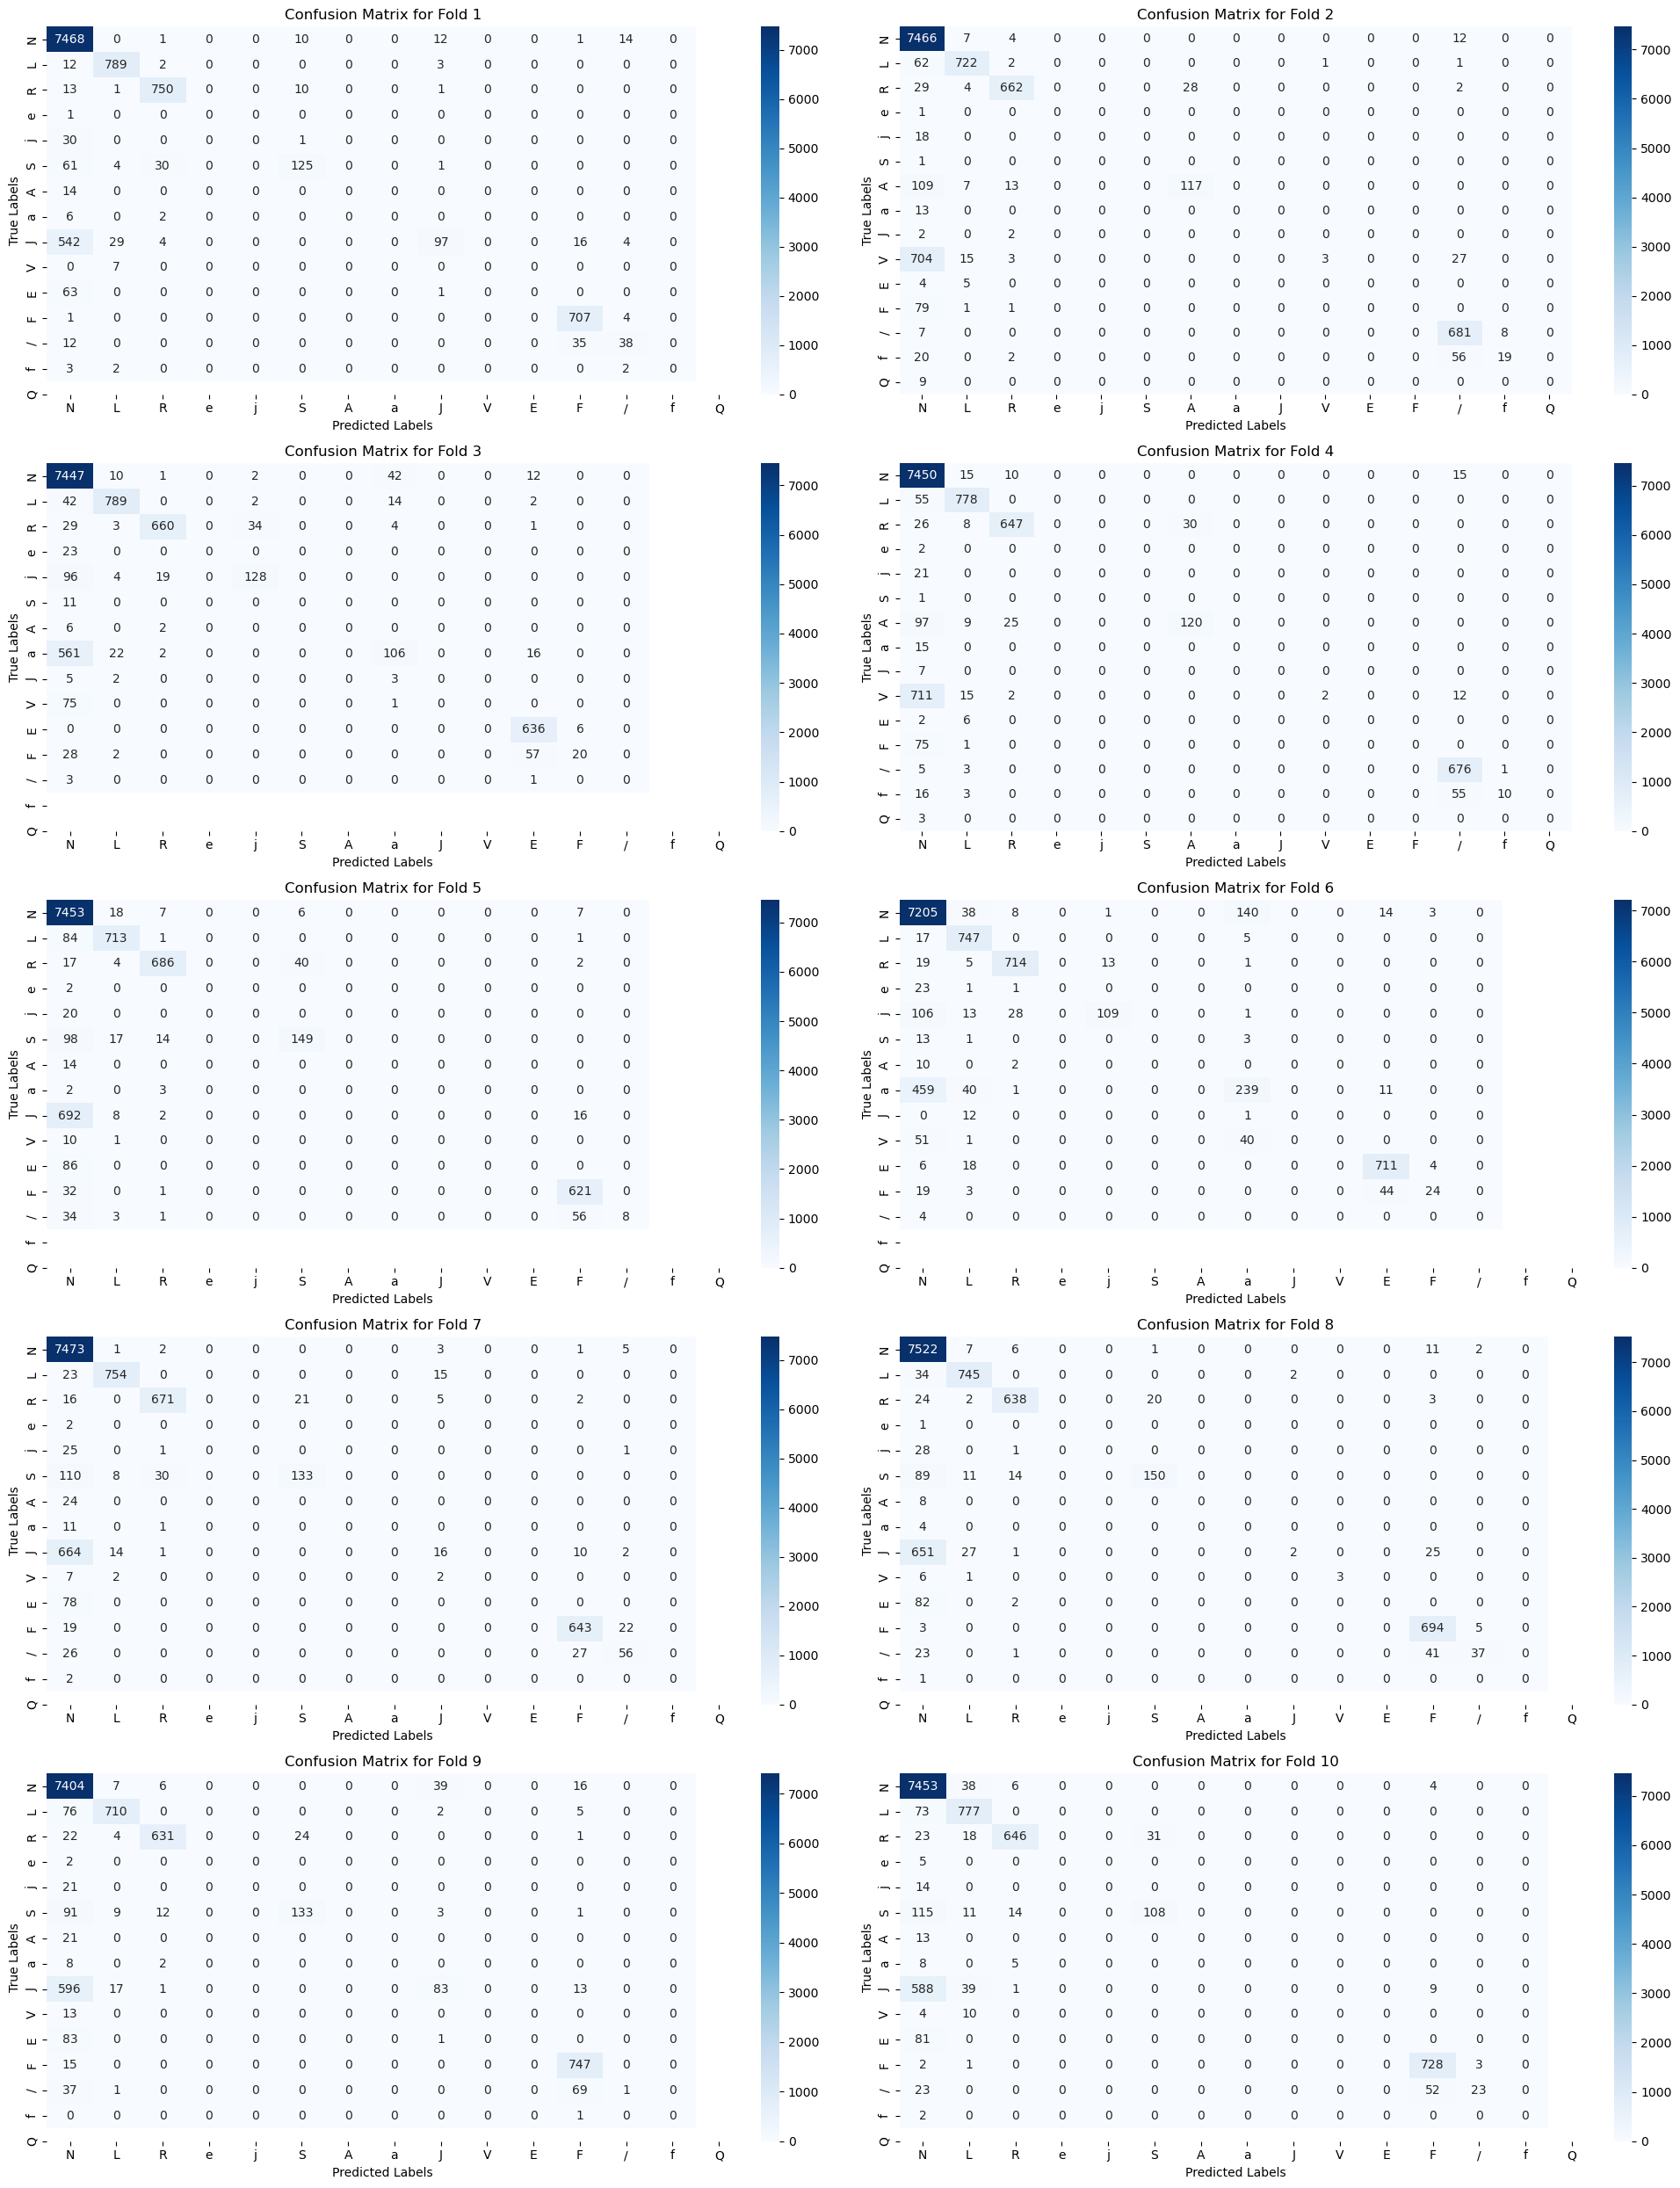

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import KFold

# Define the class labels based on your annots_list
class_labels = ['N', 'L', 'R', 'e', 'j', 'S', 'A', 'a', 'J', 'V', 'E', 'F', '/', 'f', 'Q']

def evaluate_model_on_folds(X, y, k=10):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_no = 1
    all_confusion_matrices = []

    for train, test in kfold.split(X, y):
        model_path = f'./model_fold_{fold_no}.h5'
        if not os.path.exists(model_path):
            print(f'Model file for fold {fold_no} not found!')
            continue
        
        model = keras.models.load_model(model_path)
        print(f'Model for fold {fold_no} loaded successfully.')

        X_test = X[test]
        y_test = y[test]

        start_time = time.time()
        results = model.evaluate(X_test, y_test, verbose=1)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f'Test Loss, Test Accuracy, and other metrics for fold {fold_no}: {results}')
        print(f'Evaluation time for fold {fold_no}: {elapsed_time:.2f} seconds')

        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)

        unique_classes = np.unique(y_true_classes)

        report_dict = classification_report(y_true_classes, y_pred_classes, labels=unique_classes, target_names=[class_labels[i] for i in unique_classes], output_dict=True)
        print(f"\nClassification Report for fold {fold_no}:")
        print(classification_report(y_true_classes, y_pred_classes, labels=unique_classes, target_names=[class_labels[i] for i in unique_classes]))

        cm = confusion_matrix(y_true_classes, y_pred_classes, labels=unique_classes)
        all_confusion_matrices.append(cm)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[class_labels[i] for i in unique_classes], yticklabels=[class_labels[i] for i in unique_classes])
        plt.title(f'Confusion Matrix for Fold {fold_no}')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

        fold_no += 1

    return all_confusion_matrices

# Load and preprocess data
data_path = "/home/researchgroup/mahjabeen_workspace/research/CLINet-ECG-Classification-2024/data/mit-bih/mitbih_database/"
X, y = load_mitbih_dataset(data_path)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Evaluate model on each fold
all_confusion_matrices = evaluate_model_on_folds(X, y, k=10)

# Visualize all confusion matrices in one figure
fig, axes = plt.subplots(5, 2, figsize=(20, 25))
axes = axes.ravel()

for i in range(10):
    sns.heatmap(all_confusion_matrices[i], annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
    axes[i].set_title(f'Confusion Matrix for Fold {i+1}')
    axes[i].set_xlabel('Predicted Labels')
    axes[i].set_ylabel('True Labels')

plt.tight_layout()
plt.show()


Model for fold 1 loaded successfully.
342/342 [==============================] - 9s 26ms/step - loss: 0.2603 - accuracy: 0.9126 - precision_3: 0.9241 - recall_3: 0.9015
Test Loss, Test Accuracy, and other metrics for fold 1: [0.26031213998794556, 0.9126178026199341, 0.9241159558296204, 0.9014548659324646]
Evaluation time for fold 1: 9.30 seconds
342/342 [==============================] - 7s 20ms/step

Classification Report for fold 1:
              precision    recall  f1-score   support

           N       0.91      0.99      0.95      7506
           L       0.95      0.98      0.96       806
           R       0.95      0.97      0.96       775
           e       0.00      0.00      0.00         1
           j       0.00      0.00      0.00        31
           A       0.86      0.57      0.68       221
           a       0.00      0.00      0.00        14
           J       0.00      0.00      0.00         8
           V       0.84      0.14      0.24       692
           E       0

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

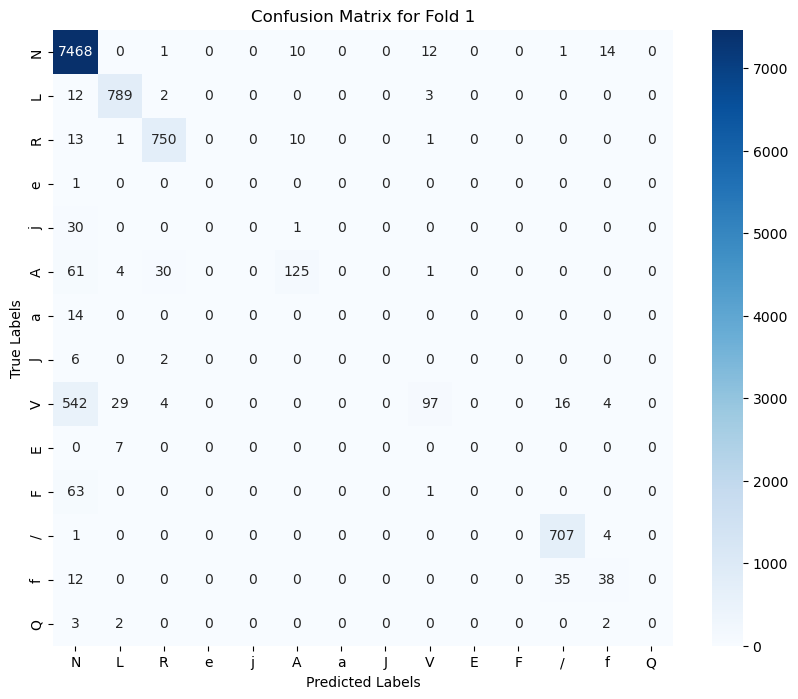

Model for fold 2 loaded successfully.
342/342 [==============================] - 9s 26ms/step - loss: 0.3384 - accuracy: 0.8848 - precision_4: 0.9001 - recall_4: 0.8746
Test Loss, Test Accuracy, and other metrics for fold 2: [0.3384236693382263, 0.8848019242286682, 0.9000941514968872, 0.8746454119682312]
Evaluation time for fold 2: 9.30 seconds
342/342 [==============================] - 7s 21ms/step

Classification Report for fold 2:
              precision    recall  f1-score   support

           N       0.88      1.00      0.93      7489
           L       0.95      0.92      0.93       788
           R       0.96      0.91      0.94       725
           e       0.00      0.00      0.00         1
           j       0.00      0.00      0.00        18
           S       0.00      0.00      0.00         1
           A       0.81      0.48      0.60       246
           a       0.00      0.00      0.00        13
           J       0.00      0.00      0.00         4
           V       0.

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

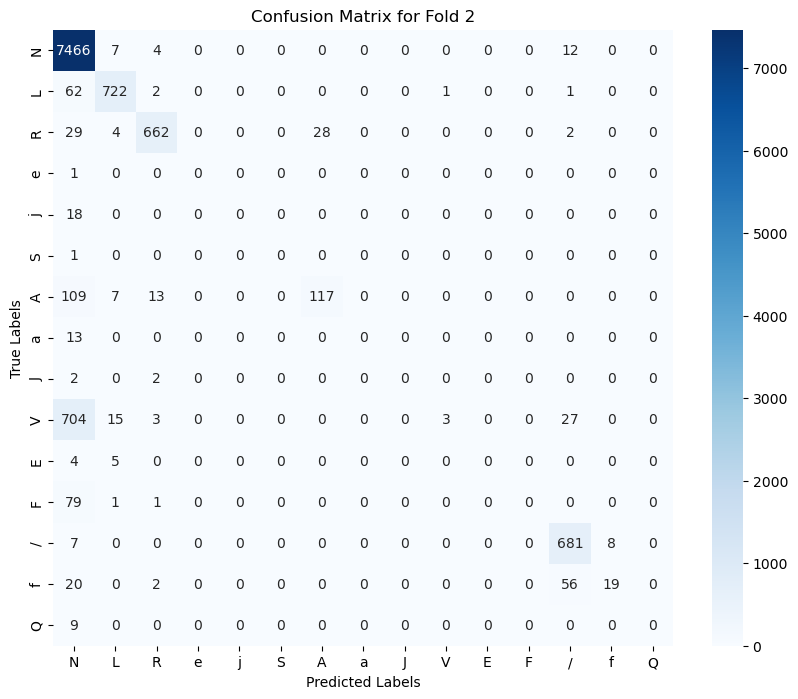

Model for fold 3 loaded successfully.
342/342 [==============================] - 9s 25ms/step - loss: 0.3261 - accuracy: 0.8954 - precision_5: 0.9157 - recall_5: 0.8743
Test Loss, Test Accuracy, and other metrics for fold 3: [0.32613301277160645, 0.8954158425331116, 0.9156684279441833, 0.8742794394493103]
Evaluation time for fold 3: 9.07 seconds
342/342 [==============================] - 7s 19ms/step

Classification Report for fold 3:
              precision    recall  f1-score   support

           N       0.89      0.99      0.94      7514
           L       0.95      0.93      0.94       849
           R       0.96      0.90      0.93       731
           j       0.00      0.00      0.00        23
           A       0.77      0.52      0.62       247
           a       0.00      0.00      0.00        11
           J       0.00      0.00      0.00         8
           V       0.62      0.15      0.24       707
           E       0.00      0.00      0.00        10
           F       0

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

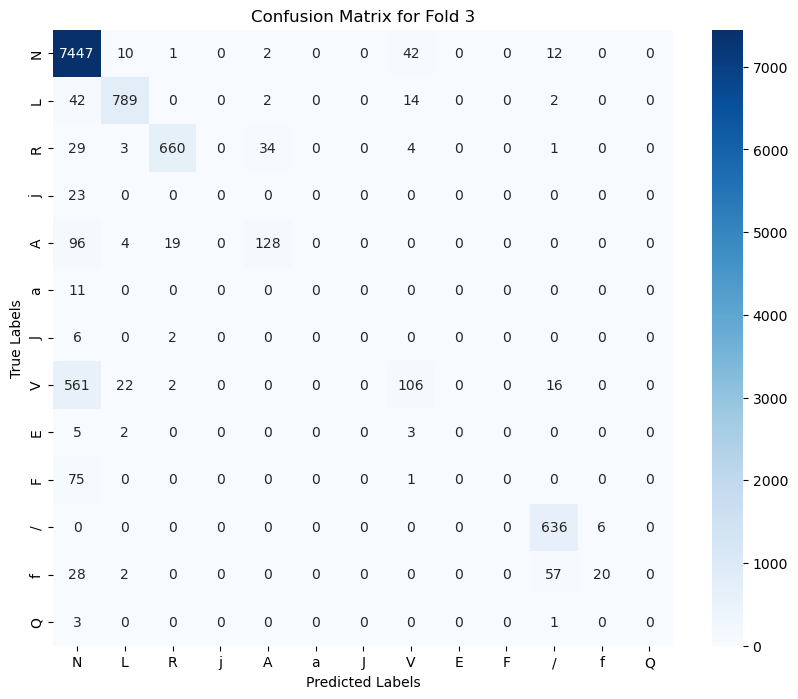

Model for fold 4 loaded successfully.
342/342 [==============================] - 9s 26ms/step - loss: 0.3262 - accuracy: 0.8860 - precision_6: 0.8944 - recall_6: 0.8796
Test Loss, Test Accuracy, and other metrics for fold 4: [0.3261929750442505, 0.8859913945198059, 0.8943989872932434, 0.879586398601532]
Evaluation time for fold 4: 9.44 seconds
342/342 [==============================] - 7s 18ms/step

Classification Report for fold 4:
              precision    recall  f1-score   support

           N       0.88      0.99      0.93      7490
           L       0.93      0.93      0.93       833
           R       0.95      0.91      0.93       711
           e       0.00      0.00      0.00         2
           j       0.00      0.00      0.00        21
           S       0.00      0.00      0.00         1
           A       0.80      0.48      0.60       251
           a       0.00      0.00      0.00        15
           J       0.00      0.00      0.00         7
           V       1.0

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

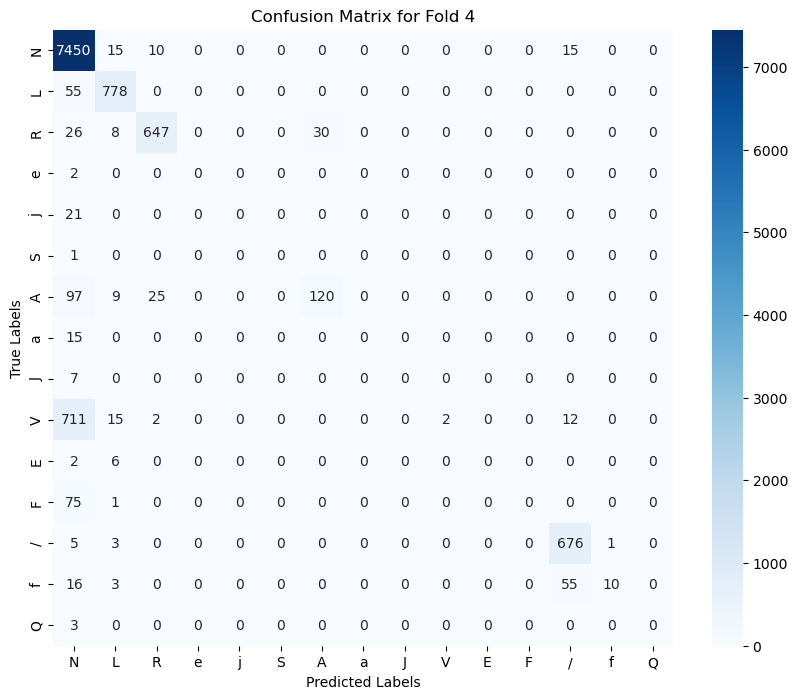

Model for fold 5 loaded successfully.
342/342 [==============================] - 9s 26ms/step - loss: 0.3661 - accuracy: 0.8811 - precision_7: 0.8869 - recall_7: 0.8757
Test Loss, Test Accuracy, and other metrics for fold 5: [0.3661406636238098, 0.8811419010162354, 0.8868606090545654, 0.8757434487342834]
Evaluation time for fold 5: 9.29 seconds
342/342 [==============================] - 8s 21ms/step

Classification Report for fold 5:
              precision    recall  f1-score   support

           N       0.87      0.99      0.93      7491
           L       0.93      0.89      0.91       799
           R       0.96      0.92      0.94       749
           e       0.00      0.00      0.00         2
           j       0.00      0.00      0.00        20
           A       0.76      0.54      0.63       278
           a       0.00      0.00      0.00        14
           J       0.00      0.00      0.00         5
           V       0.00      0.00      0.00       718
           E       0.

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

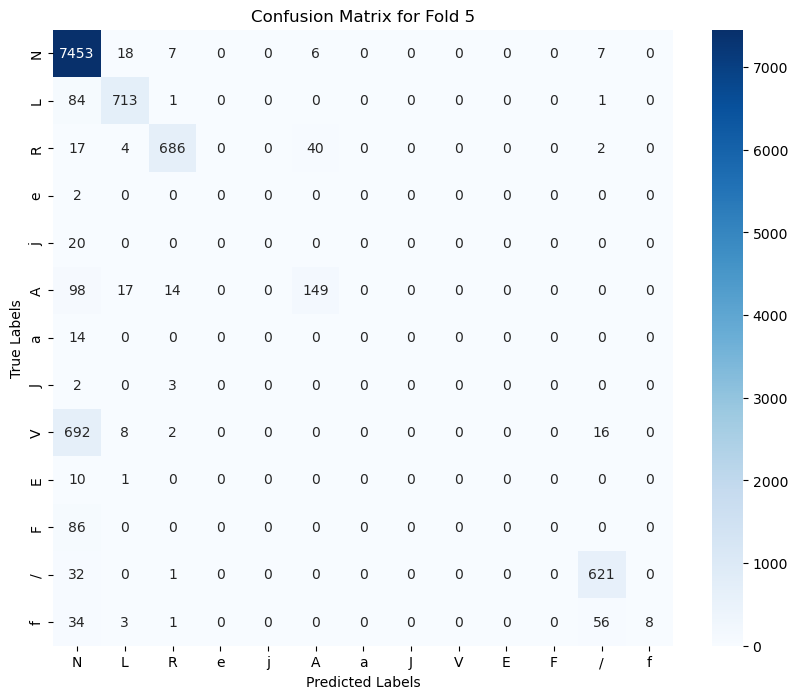

Model for fold 6 loaded successfully.
342/342 [==============================] - 9s 26ms/step - loss: 0.3310 - accuracy: 0.8920 - precision_8: 0.9096 - recall_8: 0.8773
Test Loss, Test Accuracy, and other metrics for fold 6: [0.3310488164424896, 0.8920303583145142, 0.9095911383628845, 0.8772989511489868]
Evaluation time for fold 6: 9.38 seconds
342/342 [==============================] - 7s 19ms/step

Classification Report for fold 6:
              precision    recall  f1-score   support

           N       0.91      0.97      0.94      7409
           L       0.85      0.97      0.91       769
           R       0.95      0.95      0.95       752
           j       0.00      0.00      0.00        25
           A       0.89      0.42      0.57       257
           a       0.00      0.00      0.00        17
           J       0.00      0.00      0.00        12
           V       0.56      0.32      0.41       750
           E       0.00      0.00      0.00        13
           F       0.

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

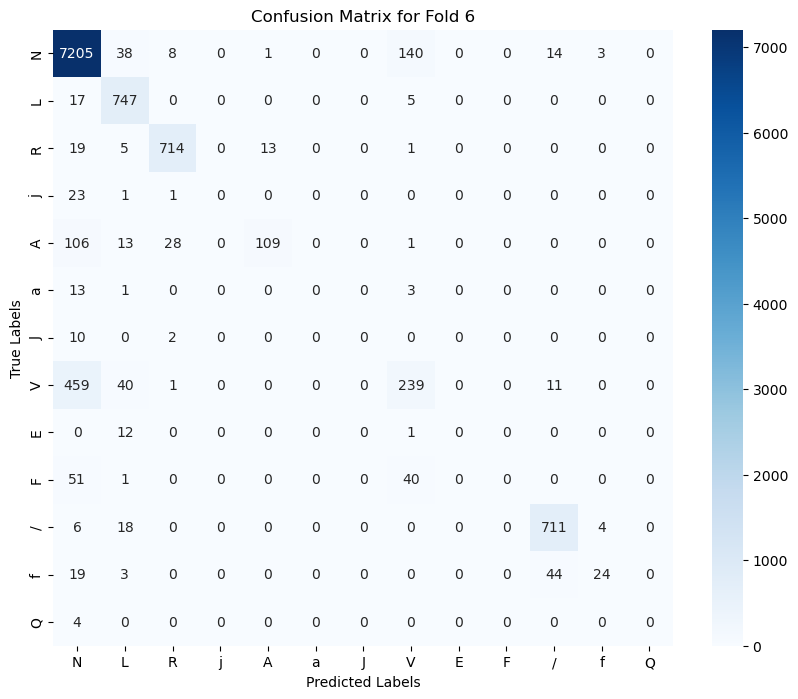

Model for fold 7 loaded successfully.
342/342 [==============================] - 9s 26ms/step - loss: 0.3055 - accuracy: 0.8918 - precision_9: 0.8975 - recall_9: 0.8857
Test Loss, Test Accuracy, and other metrics for fold 7: [0.3055456578731537, 0.8917558789253235, 0.8974596858024597, 0.8857169151306152]
Evaluation time for fold 7: 9.21 seconds
342/342 [==============================] - 7s 19ms/step

Classification Report for fold 7:
              precision    recall  f1-score   support

           N       0.88      1.00      0.94      7485
           L       0.97      0.95      0.96       792
           R       0.95      0.94      0.94       715
           e       0.00      0.00      0.00         2
           j       0.00      0.00      0.00        27
           A       0.86      0.47      0.61       281
           a       0.00      0.00      0.00        24
           J       0.00      0.00      0.00        12
           V       0.39      0.02      0.04       707
           E       0.

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

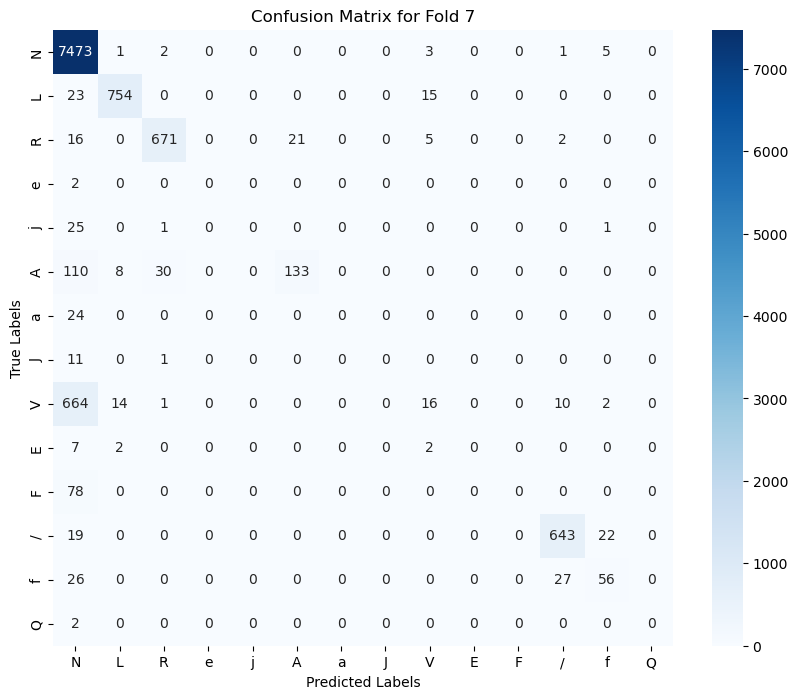

Model for fold 8 loaded successfully.
342/342 [==============================] - 9s 26ms/step - loss: 0.2912 - accuracy: 0.8960 - precision_10: 0.9042 - recall_10: 0.8915
Test Loss, Test Accuracy, and other metrics for fold 8: [0.29124605655670166, 0.8959553241729736, 0.9042138457298279, 0.8914714455604553]
Evaluation time for fold 8: 9.38 seconds
342/342 [==============================] - 7s 20ms/step

Classification Report for fold 8:
              precision    recall  f1-score   support

           N       0.89      1.00      0.94      7549
           L       0.94      0.95      0.95       781
           R       0.96      0.93      0.95       687
           e       0.00      0.00      0.00         1
           j       0.00      0.00      0.00        29
           A       0.88      0.57      0.69       264
           a       0.00      0.00      0.00         8
           J       0.00      0.00      0.00         4
           V       0.50      0.00      0.01       706
           E      

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

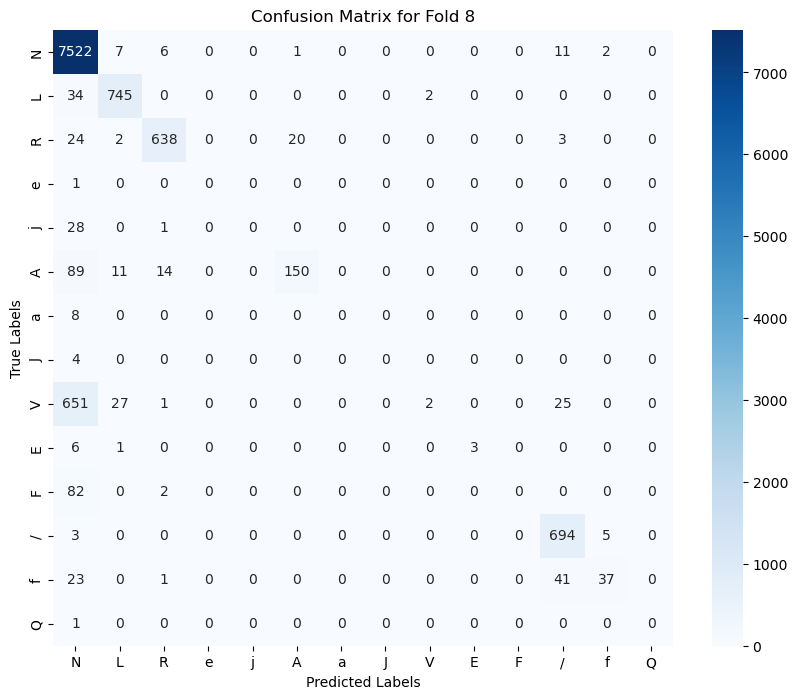

Model for fold 9 loaded successfully.
342/342 [==============================] - 9s 25ms/step - loss: 0.3440 - accuracy: 0.8885 - precision_11: 0.9012 - recall_11: 0.8788
Test Loss, Test Accuracy, and other metrics for fold 9: [0.3440340757369995, 0.8884516954421997, 0.9011824131011963, 0.878751814365387]
Evaluation time for fold 9: 9.00 seconds
342/342 [==============================] - 7s 20ms/step

Classification Report for fold 9:
              precision    recall  f1-score   support

           N       0.88      0.99      0.93      7472
           L       0.95      0.90      0.92       793
           R       0.97      0.93      0.95       682
           e       0.00      0.00      0.00         2
           j       0.00      0.00      0.00        21
           A       0.85      0.53      0.66       249
           a       0.00      0.00      0.00        21
           J       0.00      0.00      0.00        10
           V       0.65      0.12      0.20       710
           E       0

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

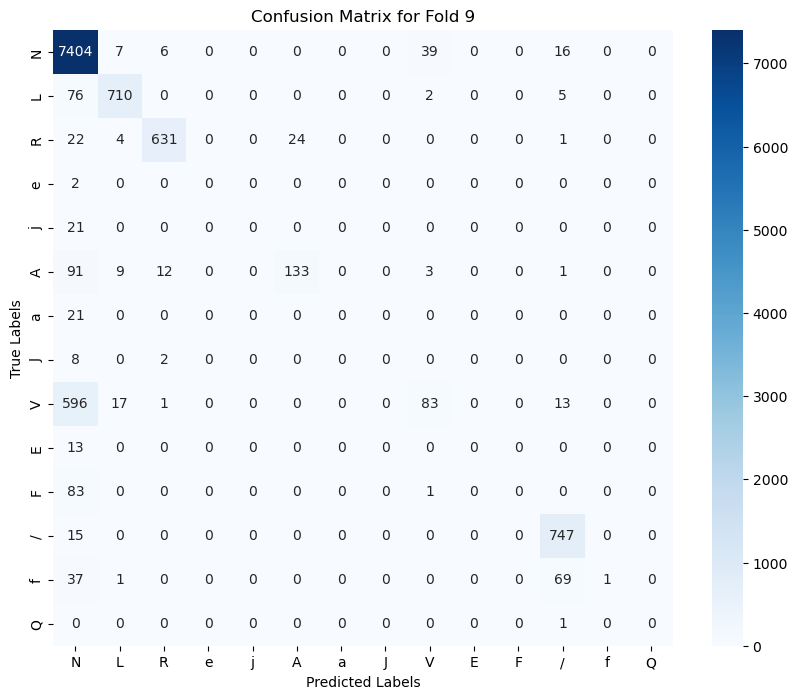

Model for fold 10 loaded successfully.
342/342 [==============================] - 9s 25ms/step - loss: 0.3335 - accuracy: 0.8908 - precision_12: 0.9004 - recall_12: 0.8814
Test Loss, Test Accuracy, and other metrics for fold 10: [0.3335370719432831, 0.8908308744430542, 0.9003552198410034, 0.8814055919647217]
Evaluation time for fold 10: 9.01 seconds
342/342 [==============================] - 7s 20ms/step

Classification Report for fold 10:
              precision    recall  f1-score   support

           N       0.89      0.99      0.94      7501
           L       0.87      0.91      0.89       850
           R       0.96      0.90      0.93       718
           e       0.00      0.00      0.00         5
           j       0.00      0.00      0.00        14
           A       0.78      0.44      0.56       248
           a       0.00      0.00      0.00        13
           J       0.00      0.00      0.00        13
           V       0.00      0.00      0.00       637
           E   

/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/researchgroup/miniconda3/envs/newtest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

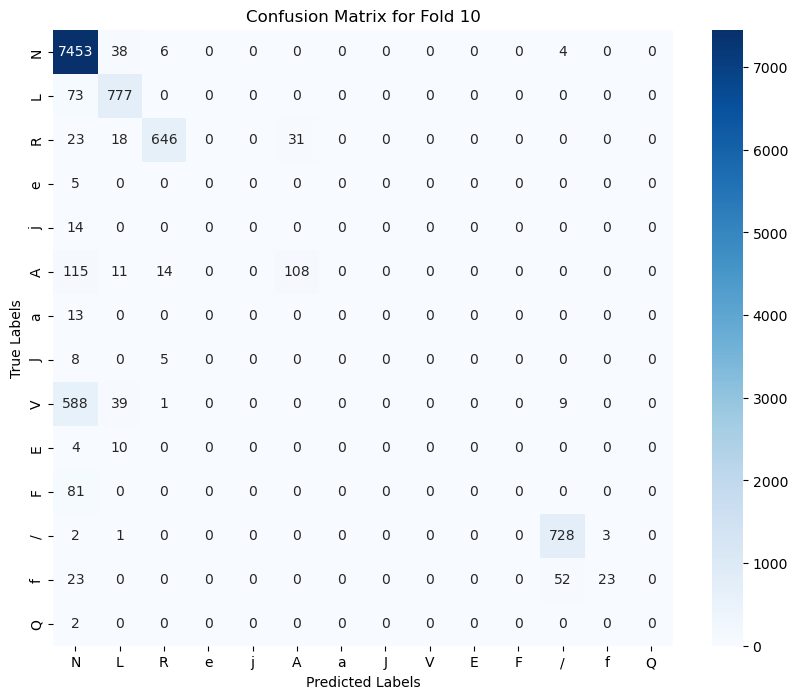


Average metrics across all folds:
Precision: 0.4280906800870358
Recall: 0.33736474623555324
F1-Score: 0.3508323154866592
Support: 788.2276923076923


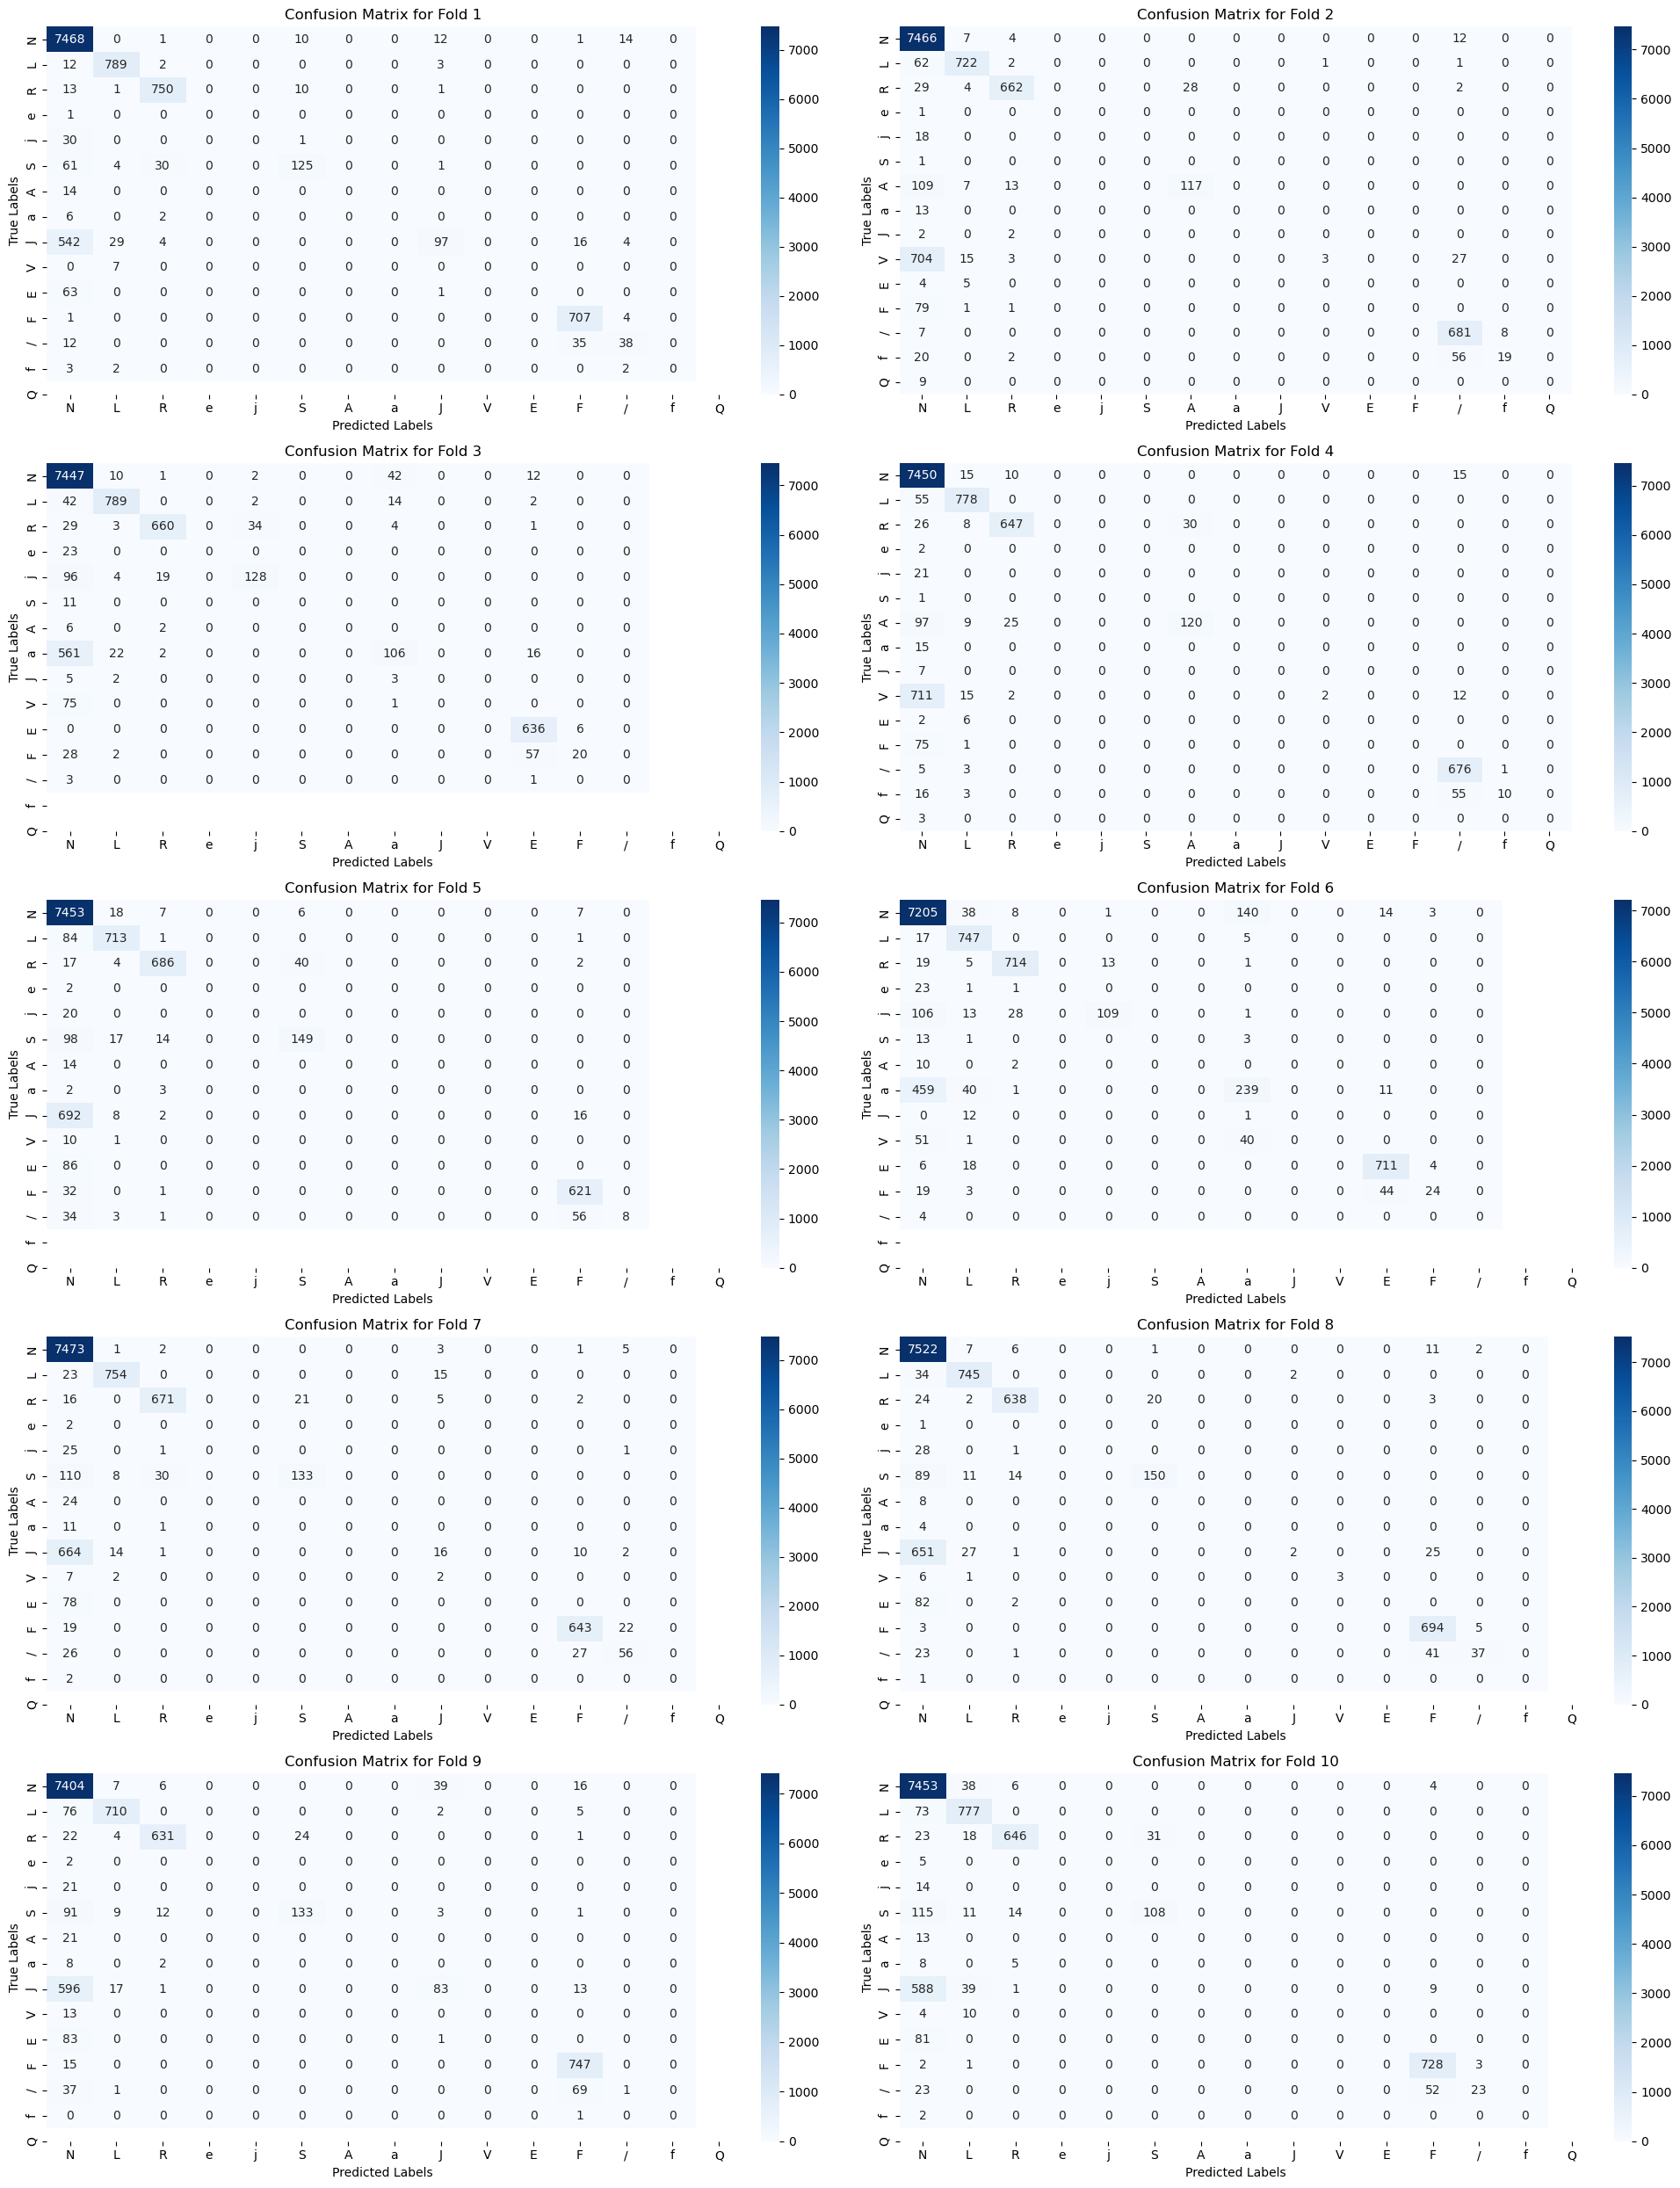

In [12]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, TimeDistributed, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time  # Correct import for time module

# Define the class labels based on your annots_list
class_labels = ['N', 'L', 'R', 'e', 'j', 'S', 'A', 'a', 'J', 'V', 'E', 'F', '/', 'f', 'Q']

def evaluate_model_on_folds(X, y, k=10):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_no = 1
    all_confusion_matrices = []
    all_metrics = []

    for train, test in kfold.split(X, y):
        model_path = f'./model_fold_{fold_no}.h5'
        if not os.path.exists(model_path):
            print(f'Model file for fold {fold_no} not found!')
            continue
        
        model = keras.models.load_model(model_path)
        print(f'Model for fold {fold_no} loaded successfully.')

        X_test = X[test]
        y_test = y[test]

        start_time = time.time()
        results = model.evaluate(X_test, y_test, verbose=1)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f'Test Loss, Test Accuracy, and other metrics for fold {fold_no}: {results}')
        print(f'Evaluation time for fold {fold_no}: {elapsed_time:.2f} seconds')

        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)

        unique_classes = np.unique(y_true_classes)

        report_dict = classification_report(y_true_classes, y_pred_classes, labels=unique_classes, target_names=[class_labels[i] for i in unique_classes], output_dict=True)
        print(f"\nClassification Report for fold {fold_no}:")
        print(classification_report(y_true_classes, y_pred_classes, labels=unique_classes, target_names=[class_labels[i] for i in unique_classes]))

        cm = confusion_matrix(y_true_classes, y_pred_classes, labels=unique_classes)
        all_confusion_matrices.append(cm)

        # Collect metrics for averaging later
        metrics = precision_recall_fscore_support(y_true_classes, y_pred_classes, labels=unique_classes)
        all_metrics.append(metrics)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[class_labels[i] for i in unique_classes], yticklabels=[class_labels[i] for i in unique_classes])
        plt.title(f'Confusion Matrix for Fold {fold_no}')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

        fold_no += 1

    return all_confusion_matrices, all_metrics

# Function to calculate average metrics
def calculate_average_metrics(all_metrics):
    avg_precision = []
    avg_recall = []
    avg_fscore = []
    avg_support = []

    for metrics in all_metrics:
        precision, recall, fscore, support = metrics
        avg_precision.append(np.mean(precision))
        avg_recall.append(np.mean(recall))
        avg_fscore.append(np.mean(fscore))
        avg_support.append(np.mean(support))

    return {
        "avg_precision": np.mean(avg_precision),
        "avg_recall": np.mean(avg_recall),
        "avg_fscore": np.mean(avg_fscore),
        "avg_support": np.mean(avg_support)
    }

# Load and preprocess data
data_path = "/home/researchgroup/mahjabeen_workspace/research/CLINet-ECG-Classification-2024/data/mit-bih/mitbih_database/"
X, y = load_mitbih_dataset(data_path)
X = X.reshape((X.shape[0], X.shape[1], 1))





# Evaluate model on each fold
all_confusion_matrices, all_metrics = evaluate_model_on_folds(X, y, k=10)

# Calculate and print average metrics
average_metrics = calculate_average_metrics(all_metrics)

print("\nAverage metrics across all folds:")
print(f"Precision: {average_metrics['avg_precision']}")
print(f"Recall: {average_metrics['avg_recall']}")
print(f"F1-Score: {average_metrics['avg_fscore']}")
print(f"Support: {average_metrics['avg_support']}")

# Visualize all confusion matrices in one figure
fig, axes = plt.subplots(5, 2, figsize=(20, 25))
axes = axes.ravel()

for i in range(10):
    sns.heatmap(all_confusion_matrices[i], annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
    axes[i].set_title(f'Confusion Matrix for Fold {i+1}')
    axes[i].set_xlabel('Predicted Labels')
    axes[i].set_ylabel('True Labels')

plt.tight_layout()
plt.show()
